In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import re
import seaborn as sb
sb.set()

In [11]:
def is_experiment_start(line):
    return line.startswith('evaluating for')

def skip_n_experiments(input_file, experiment_num):
    current_experiment = 0
    while current_experiment < experiment_num:
        line = input_file.readline()
        if is_experiment_start(line):
            current_experiment += 1
            
def get_metrics(line):
    regexp = re.compile(r'[a-zA-Z0-9_]+\: [0-9\.]+')
    result = {}
    for metric_str in regexp.findall(line):
        metric, value = metric_str.split(': ')
        result[metric] = float(value)
    return result
    
            
def parse_experiment(experiment_log):
    current_recommender = None
    result = []
    cnt =0
    metrics = []
    for line in experiment_log:
            if line.startswith('evaluating '):
                current_recommender = line.split(' ')[1]
                metrics = []
            if 'val_ndcg_at_40' in line:
                    metrics.append(get_metrics(line))
            try:
                experiment_results = json.loads(line)
                experiment_results['model_name'] =  current_recommender
                experiment_results['metrics_history'] = metrics
                result.append(experiment_results)
            except:
                pass
    experiment_results = {}
    experiment_results['model_name'] =  current_recommender
    experiment_results['metrics_history'] = metrics
    result.append(experiment_results)
    return result

def get_data_from_logs(logfile, experiment_num):
    current_experiment = 0
    with open(logfile) as input_file:
        skip_n_experiments(input_file, experiment_num)
        experiment_log = []
        for line in input_file:
            if is_experiment_start(line):
                break
            else:
                experiment_log.append(line.strip())
        return parse_experiment(experiment_log)

In [12]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [13]:
experiment_logs = './results/booking_config_2021_01_22T17_14_18/stdout'
data = get_data_from_logs(experiment_logs, 0)
data

[{'precision@4': 0.007007007007007007,
  'SPS@4': 0.028028028028028028,
  'ndcg@4': 0.017856057783084602,
  'ndcg@40': 0.06295764869110348,
  'model_build_time': 0.10741138458251953,
  'model_inference_time': 0.024637937545776367,
  'model_metadata': {},
  'model_name': 'top_recommender',
  'metrics_history': []},
 {'precision@4': 0.08658658658658659,
  'SPS@4': 0.34234234234234234,
  'ndcg@4': 0.25903935613792917,
  'ndcg@40': 0.33306639981991504,
  'model_build_time': 0.008645057678222656,
  'model_inference_time': 0.030905723571777344,
  'model_metadata': {},
  'model_name': 'conditional_top_recommender',
  'metrics_history': []},
 {'precision@4': 0.06306306306306306,
  'SPS@4': 0.25225225225225223,
  'ndcg@4': 0.1919834997167693,
  'ndcg@40': 0.24192708268163188,
  'model_build_time': 4.923978090286255,
  'model_inference_time': 13.493070602416992,
  'model_metadata': {},
  'model_name': 'svd_recommender',
  'metrics_history': []},
 {'precision@4': 0.1066066066066066,
  'SPS@4': 0.

In [14]:
df = pd.DataFrame(data).set_index('model_name').sort_values('SPS@4')
df

,precision@4,SPS@4,ndcg@4,ndcg@40,model_build_time,model_inference_time,model_metadata,metrics_history
model_name,,,,,,,,
top_recommender,0.007007,0.028028,0.017856,0.062958,0.107411,0.024638,{},[]
svd_recommender,0.063063,0.252252,0.191983,0.241927,4.923978,13.493071,{},[]
conditional_top_recommender,0.086587,0.342342,0.259039,0.333066,0.008645,0.030906,{},[]
transitions_chain_recommender,0.106607,0.426426,0.326045,0.413072,2.072536,0.115009,{},[]
APREC-GMLPHE-Lambdarank-256-0.5,0.124124,0.496496,0.399830,0.475280,16445.091523,42.111238,"{'epochs_trained': 39, 'best_val_ndcg': 0.5086...","[{'loss': 3.9737, 'ndcg_at_40': 0.1652, 'Succe..."
APREC-GMLPHE-Lambdarank-256-0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'loss': 3.9737, 'ndcg_at_40': 0.1652, 'Succe..."


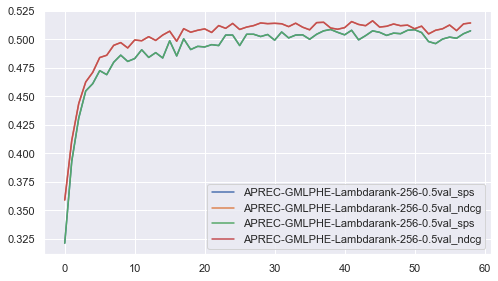

In [15]:
def get_metric(metric_history, metric_name):
    result = []
    for item in metric_history:
        try:
            result.append(item[metric_name])
        except:
            print(item)
    return result

plt.figure(figsize=(8, 4.5))
for recommender in data:
    if len(recommender['metrics_history']) > 0:
        history = recommender['metrics_history']
        ndcg = get_metric(history, 'ndcg_at_40')
        val_ndcg = get_metric(history, 'val_ndcg_at_40')
        
        success = get_metric(history, 'Success_at_4')
        val_success = get_metric(history, 'val_Success_at_4')
        
        plt.plot(val_success, label=recommender['model_name'] + "val_sps")
        #plt.plot(success, label=recommender['model_name'] + "sps")
        
        plt.plot(val_ndcg, label=recommender['model_name'] + "val_ndcg")
        #plt.plot(ndcg, label=recommender['model_name'] + "ndcg")
        #plt.plot(val_success, label=recommender['model_name'] + "_val_sps")
plt.legend()
